<a href="https://colab.research.google.com/github/repoocsov/Build_Week_1/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pre-Model**

### Splitting some Cleaning

In [0]:
import pandas as pd
import numpy as np
colnames = ['site', 'vendor', 'timestamp', 'score', 'btc_amount', 'comment']
df = pd.read_csv('2020-01-13-kilos-6dnms-reviews.csv', error_bad_lines=False, lineterminator='\n', names=colnames, header=None, encoding='UTF-8')

In [2]:
df.shape

(235652, 6)

In [3]:
df.columns

Index(['site', 'vendor', 'timestamp', 'score', 'btc_amount', 'comment'], dtype='object')

In [4]:
df.tail(5)

,site,vendor,timestamp,score,btc_amount,comment
235647,Apollon,DrSommer,1578825660,1,0.001541,"Good stealth, good product"
235648,Apollon,DrSommer,1578827520,1,0.002712,very good
235649,Apollon,DrSommer,1578827760,1,0.001603,Excellent as usual
235650,Apollon,DrSommer,1578827820,1,0.001726,Excellent as usual
235651,Apollon,DrSommer,1578827820,1,0.002096,"excellent stealth, fast shipping, original bli..."


In [5]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# GETTING BTC PRICE ON THOSE DATES
''' btc price dataframe '''
df2 = pd.read_csv('btc.csv')
subset = df2[['PriceUSD', 'date']]
subset['date'] = pd.to_datetime(subset['date'], infer_datetime_format=True)


''' original dataframe '''

# ZEROES CURRENTLY DROPPED
#df['timestamp'].replace({0: 1528825660})
df['timestamp'][0] = np.nan
df['timestamp'] = pd.to_datetime(df['timestamp'], origin='unix', unit='s', utc=True)
df['timestamp'] = [x.replace(tzinfo=None).date() for x in df['timestamp']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = pd.merge(df, subset, how='inner', left_on='timestamp', right_on='date')
df

,site,vendor,timestamp,score,btc_amount,comment,PriceUSD,date
0,Empire,ofgrey,2018-02-19,1,0.002418,"Good quality product, everything is very well ...",11139.355730,2018-02-19
1,Empire,ofgrey,2018-02-19,1,0.000092,good best price thank you,11139.355730,2018-02-19
2,Empire,ofgrey,2018-02-19,1,0.002418,Best vendor !!!,11139.355730,2018-02-19
3,Empire,ofgrey,2018-02-19,1,0.000150,good thank you,11139.355730,2018-02-19
4,Empire,DrunkDragon,2018-03-02,-1,0.000113,"scam,scam scam,save urself the trouble.SCAM.",11014.058470,2018-03-02
...,...,...,...,...,...,...,...,...
225409,Apollon,DrSommer,2020-01-12,1,0.001541,"Good stealth, good product",8164.549993,2020-01-12
225410,Apollon,DrSommer,2020-01-12,1,0.002712,very good,8164.549993,2020-01-12
225411,Apollon,DrSommer,2020-01-12,1,0.001603,Excellent as usual,8164.549993,2020-01-12
225412,Apollon,DrSommer,2020-01-12,1,0.001726,Excellent as usual,8164.549993,2020-01-12


In [6]:
""" FEATURES """
# CATAGORICAL: site, vendor, comment
# NUMERIC: timestamp, btc_amount

""" TARGET """
# score


# Score represents the sentiment of the comment associated with the purchase. 1 being positive, 0 neutral, and -1 negative.
# In addition to the accuracy metric...‘balanced_accuracy’ as there is a heavy class imbalance.

# Distribution of the target
"""
 93.9% positive
 3.2% negative
 2.8% neutral

 This is a multi-class classification problem with three categories.
 The mean baseline is 93.9 %
"""
df['score'].value_counts(normalize=True)

 1    0.938526
-1    0.032079
 0    0.029395
Name: score, dtype: float64

In [7]:
df['timestamp'].describe()

count                  225414
unique                    654
top       2019-11-06 00:00:00
freq                     2505
first     2018-02-19 00:00:00
last      2020-01-12 00:00:00
Name: timestamp, dtype: object

In [0]:
# timestamp has missing values (zeros). It would be nice to split the data this way otherwise.
# Order of stratification importance...
# score, timestamp/site
from sklearn.model_selection import train_test_split

target = 'score'
features = ['site', 'vendor', 'btc_amount', 'comment', 'PriceUSD', 'date']

y_df = df[target]
X_df = df[features]

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((180331, 6), (45083, 6), (180331,), (45083,))

In [10]:
# Repeating to get a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=49, stratify=y_train)

X_train.shape, X_val.shape, X_test.shape

((144264, 6), (36067, 6), (45083, 6))

### Wrangle

In [0]:
""" WRANGLE FUNCTION """

def wrangle(dataframe):

  # DATE
  dataframe['date'] = dataframe['date'].astype(int)

  # COMMENTS
  dataframe['comment'] = dataframe['comment'].replace(np.nan, '')

  # DOLLAR VALUE
  dataframe['price'] = dataframe['PriceUSD'] * dataframe['btc_amount']

  # RENAMING COLUMNS
  dataframe = dataframe.rename({'priceUSD': 'bitcoin_price'})

  # ORGANIZING COLUMNS
  dataframe = dataframe.reindex(columns=['site', 'vendor', 'date', 'comment', 'price', 'btc_amount'])

  return dataframe

In [12]:
wrangle(X_train)
wrangle(X_val)
wrangle(X_test)

,site,vendor,date,comment,price,btc_amount
7158,Cannazon,Briefsoven,1555977600000000000,"Came very quickly, excellent quality, great pr...",34.435427,0.006210
19599,Cannazon,radarbreeder,1559606400000000000,"all perfect, thanks",58.453416,0.007641
80494,Apollon,youngbanger,1568246400000000000,"Fucking good stuff,fucking great stealth shipp...",63.783312,0.006131
45774,Empire,DrunkDragon,1564704000000000000,750 000 codes 0 correct so I don't believe in ...,1.206703,0.000115
44418,Empire,SATAII,1564531200000000000,No feedback comment,68.810629,0.006841
...,...,...,...,...,...,...
109950,Empire,DrHappy,1570579200000000000,"Schnelle Lieferung, gute Ware \r\nGerne wieder",197.872553,0.023013
10944,Cannazon,Bllume,1557532800000000000,2DD fr den preis super Zeug! sehr freundlicher...,274.078230,0.037416
112814,Apollon,Germanapotheke,1570752000000000000,Danke perfekt,0.901041,0.000109
79125,Cryptonia,aKINDercare,1568073600000000000,recommend this vendor and product.,29.249261,0.002900


# **Building a Model**

In [0]:
%%capture
import sys
import numpy as np
import pandas as pd

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5

In [14]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier() 
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['site', 'vendor', 'comment'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'site',
                                          'data_type': dtype('O'),
                                          'mapping': Cryptonia    1
Empire       2
Apollon      3
CannaHome    4
Cannazon     5
NaN         -2
dtype: int64},
                                         {'col': 'vendor',
                                          'data_type': dtype('O'),
                                          'mapping': valhalla              1
PremierLeague...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
              

In [15]:
# ACCURACY SCORE (BASELINE WAS ~.93)
print("The accuracy is:", pipeline.score(X_val, y_val))

The accuracy is: 0.9472925388859622


In [16]:
# AVERAGE RECALL SCORE
from sklearn.metrics import balanced_accuracy_score

"""
The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets.
It is defined as the average of recall obtained on each class.
"""
''' Recall literally is how many of the true positives were recalled (found), i.e. how many of the correct hits were also found. '''

y_pred = [1] * len(y_val)
print("The average recall with just guessing 1 for every instance is:", balanced_accuracy_score(y_val, y_pred))

The average recall with just guessing 1 for every instance is: 0.3333333333333333


In [17]:
y_pred = pipeline.predict(X_val)
print("The average recall is with the model:", balanced_accuracy_score(y_val, y_pred))

The average recall is with the model: 0.4480461956453882


### XGBoost Model


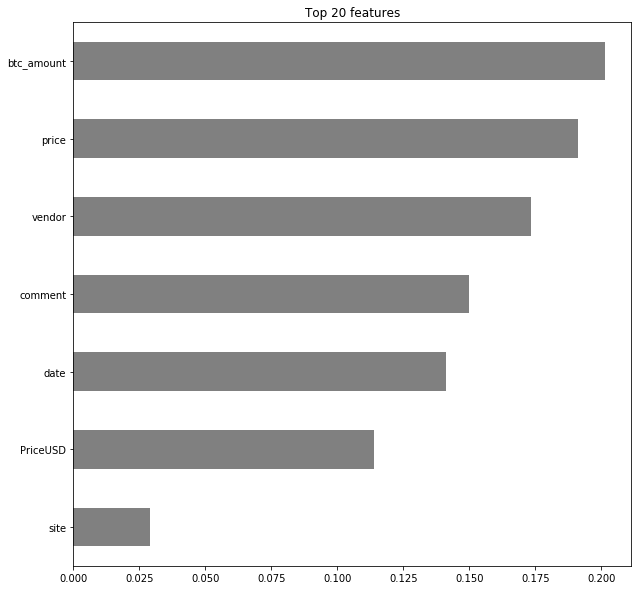

In [18]:
""" NORMAL FEATURE IMPORTANCE """
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [19]:
""" PERMUTATION FEATURE IMPORTANCE """
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=3,
                                              min_child_weight=1, missing=None,
                                              n_estimators=100, n_jobs=-1,
                                              nthread=None,
                                              objective='multi:softprob',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                    

In [21]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

comment      -0.000028
price         0.000172
PriceUSD      0.000227
site          0.000560
btc_amount    0.000821
vendor        0.000976
date          0.001026
dtype: float64

In [25]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0010 ± 0.0004,date
0.0010 ± 0.0001,vendor
0.0008 ± 0.0001,btc_amount
0.0006 ± 0.0001,site
0.0002 ± 0.0000,PriceUSD
0.0002 ± 0.0000,price
-0.0000 ± 0.0000,comment


# **Exploration**

In [39]:
"""
PLANS:
- Drop 'cryptonia' rows as the scores aren't accurate
- Make exploratory visualizations.
- Missing dates should be averaged
- Date needs to be normalized
- SMOTE CLASS BALANCER
- Check differences in sentiment between the 6 sites and plot them (normalized)

- Feature creation with the comments
    spacy sklearn
    count vectorizor
    tfidf vectorizor
    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
"""

'\nPLANS:\n- Make exploratory visualizations.\n- Missing dates should be averaged\n- Date needs to be normalized\n- SMOTE CLASS BALANCER\n- Check differences in sentiment between the 6 sites and plot them (normalized)\n\n- Feature creation with the comments\n    spacy sklearn\n    count vectorizor\n    tfidf vectorizor\n    https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html\n'

In [38]:
X_train['comment'] = X_train['comment'].replace({'No feedback left.': '',
                            'No feedback comment': '',
                            'No Comment': ''})
X_train['comment_length'] = [len(x) for x in X_train['comment']]
X_train.tail(5)

,site,vendor,btc_amount,comment,PriceUSD,date,price,comment_length
219646,Apollon,TheShop,0.001367,,7229.397101,1577664000000000000,9.881501,0
126616,Empire,EUCarder,0.000017,,8213.709039,1571529600000000000,0.141276,0
35859,Cryptonia,pornseller,0.000300,All good,11346.837150,1562976000000000000,3.404051,8
125620,Empire,DrunkDragon,0.000115,does not work. trash.,7948.477337,1571443200000000000,0.910101,21
135479,Empire,canjam420,0.001982,"yep thats RSO , good stuff",8656.655178,1571961600000000000,17.159222,26


In [61]:
pip install spacy

In [64]:
from spacy.lang.en import English

test_text = "This is a test sentence. I should be doing this in unit four..."

# Load English tokenizer, tagger, parser, NER and word vectors
nlp = English()

my_doc = nlp(test_text)

token_list = []
for token in my_doc:
    token_list.append(token.text)
print(token_list)

['This', 'is', 'a', 'test', 'sentence', '.', 'I', 'should', 'be', 'doing', 'this', 'in', 'unit', 'four', '...']


# **Charts**

In [42]:
df['site'].value_counts()

Empire       83008
Cannazon     55740
Apollon      41456
Cryptonia    35223
CannaHome     9987
Name: site, dtype: int64

In [0]:
# Subsets of the sites
empire = df[df['site'] == 'Empire']
cannazon = df[df['site'] == 'Cannazon']
apollon = df[df['site'] == 'Apollon']
cryptonia = df[df['site'] == 'Cryptonia']
cannahome = df[df['site'] == 'CannaHome']

In [46]:
empire['score'].value_counts(normalize=True)

 1    0.856219
-1    0.075186
 0    0.068596
Name: score, dtype: float64

In [47]:
cannazon['score'].value_counts(normalize=True)

 1    0.981826
 0    0.013348
-1    0.004826
Name: score, dtype: float64

In [53]:
apollon['score'].value_counts(normalize=True)

 1    0.982102
-1    0.016644
 0    0.001254
Name: score, dtype: float64

In [59]:
cannahome['score'].value_counts(normalize=True)

 1    0.983278
 0    0.013618
-1    0.003104
Name: score, dtype: float64

In [0]:
""" PLOT """
import matplotlib.pyplot as plt